## Spam or Ham (not Spam) Email Text Classification Project using TF-IDF

### Importing needed modules

In [81]:
import pandas as pd
import numpy as np

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download("stopwords")
nltk.download("wordnet")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading the dataset

In [8]:
data = pd.read_csv("../data/spam.csv", encoding = "ISO-8859-1")

In [9]:
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


### Cleaning the Data

In [51]:
#Drops the last three columns due to extra commas at the end of some sentences
cleaned_data = data.iloc[:, :2]

cleaned_data

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [52]:
# Renaming the columns
cleaned_data = cleaned_data.rename(columns = {"v1": "label", "v2": "message"})

In [37]:
cleaned_data.shape

(5572, 2)

In [38]:
cleaned_data.duplicated().sum()

np.int64(403)

In [ ]:
# Removing duplicates | Only removed exact duplicates as it only adds bias
cleaned_data = cleaned_data.drop_duplicates()

In [40]:
cleaned_data.duplicated().sum()

np.int64(0)

In [41]:
# Checking for NaN Values
cleaned_data.isna().sum()

label      0
message    0
dtype: int64

In [42]:
# Checking the label column
cleaned_data['label'].unique()

array(['ham', 'spam'], dtype=object)

In [54]:
# Converting ham: 0, spam: 1
cleaned_data['label'] = np.where(cleaned_data['label'] == 'ham', 0, 1)

cleaned_data['label'].unique()

array([0, 1])

### Text Preprocessing

In [55]:
# Removing special characters, if any, in the message column and lowering all text
cleaned_data['message'] = cleaned_data['message'].replace(regex = r"[^a-zA-Z\s+]", value = "").str.lower()
cleaned_data["message"]

0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2       free entry in  a wkly comp to win fa cup final...
3             u dun say so early hor u c already then say
4       nah i dont think he goes to usf he lives aroun...
                              ...                        
5567    this is the nd time we have tried  contact u u...
5568                   will  b going to esplanade fr home
5569    pity  was in mood for that soany other suggest...
5570    the guy did some bitching but i acted like id ...
5571                            rofl its true to its name
Name: message, Length: 5169, dtype: object

In [56]:
# Lemmatizing the column
def lemmatize(document: str):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    set_stopwords = set(stopwords.words('english'))

    for word in document.split():
        if word not in set_stopwords:
            lemmatized_words.append(lemmatizer.lemmatize(word))

    return " ".join(lemmatized_words)

cleaned_data['lemmatized_message'] = cleaned_data['message'].map(lambda x: lemmatize(x))


In [57]:
cleaned_data['lemmatized_message']

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry wkly comp win fa cup final tkts st ...
3                     u dun say early hor u c already say
4                nah dont think go usf life around though
                              ...                        
5567    nd time tried contact u u pound prize claim ea...
5568                            b going esplanade fr home
5569                           pity mood soany suggestion
5570    guy bitching acted like id interested buying s...
5571                                       rofl true name
Name: lemmatized_message, Length: 5169, dtype: object

In [59]:
corpus = cleaned_data['lemmatized_message'].to_list()
corpus

['go jurong point crazy available bugis n great world la e buffet cine got amore wat',
 'ok lar joking wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry questionstd txt ratetcs apply over',
 'u dun say early hor u c already say',
 'nah dont think go usf life around though',
 'freemsg hey darling week word back id like fun still tb ok xxx std chgs send rcv',
 'even brother like speak treat like aid patent',
 'per request melle melle oru minnaminunginte nurungu vettam set callertune caller press copy friend callertune',
 'winner valued network customer selected receivea prize reward claim call claim code kl valid hour',
 'mobile month u r entitled update latest colour mobile camera free call mobile update co free',
 'im gonna home soon dont want talk stuff anymore tonight k ive cried enough today',
 'six chance win cash pound txt csh send cost pday day + tsandcs apply reply hl info',
 'urgent week free membership prize jackpot txt word claim tc wwwdbuk

### Train-test split

In [104]:
X = cleaned_data['lemmatized_message']
y = cleaned_data['label']

In [105]:
#Spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) #Random state initialized for reproducibility

### TF-IDF Model

In [107]:
tfidf = TfidfVectorizer(ngram_range = (1, 2), max_features = 1000)

X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

### Model Training

In [108]:
# Function for generating metrics
def get_metrics(y_actual, y_predicted):
    return (accuracy_score(y_actual, y_predicted), f1_score(y_actual, y_predicted), recall_score(y_actual, y_predicted))

In [109]:
from collections import defaultdict

models = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "RandomForestClassifier": RandomForestClassifier()
}

train_metrics = defaultdict(list)

test_metrics = defaultdict(list)

# Model Training
for name, model in models.items():
    print(f"Training {name}")
    model.fit(X_train, y_train)

    # train metrics
    y_pred_train = model.predict(X_train)
    acc, f1, recall = get_metrics(y_train, y_pred_train)

    train_metrics[name].append(acc)
    train_metrics[name].append(f1)
    train_metrics[name].append(recall)

    # test metrics
    y_pred_test = model.predict(X_test)
    acc, f1, recall = get_metrics(y_test, y_pred_test)

    test_metrics[name].append(acc)
    test_metrics[name].append(f1)
    test_metrics[name].append(recall)

Training MultinomialNB
Training BernoulliNB
Training RandomForestClassifier


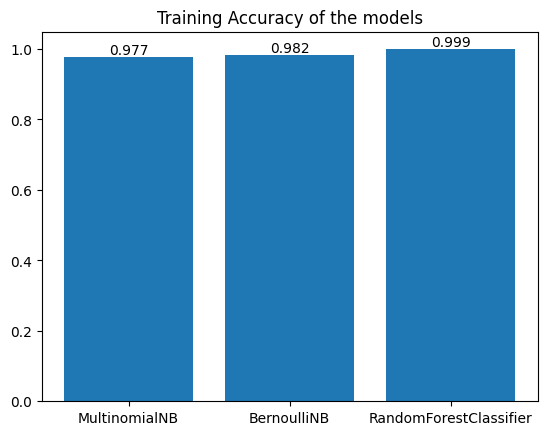

In [110]:
# Graphing training accuracy
accuracies = [acc[0] for acc in train_metrics.values()]

plt.bar(x = train_metrics.keys(), height = accuracies)
for i, v in enumerate(accuracies):
    plt.text(i, v, str(round(v, 3)), ha='center', va='bottom')
plt.title("Training Accuracy of the models")
plt.show()

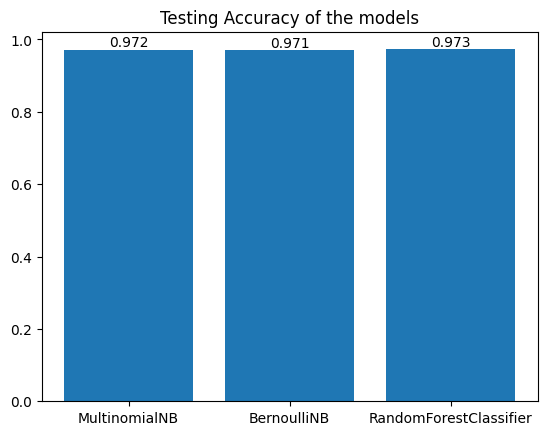

In [111]:
# Graphing testing accuracy
accuracies = [acc[0] for acc in test_metrics.values()]

plt.bar(x = test_metrics.keys(), height = accuracies)
for i, v in enumerate(accuracies):
    plt.text(i, v, str(round(v, 3)), ha='center', va='bottom')
plt.title("Testing Accuracy of the models")
plt.show()

### Conclusion

- In terms of model prediction power and accuracy on the testing data split, all models perform relatively the same.
- Multinomial Naive-Bayes performed marginally the best out of the 2 other models